### ASTR 8070: Astrostatistics
***S. R. Taylor***
___

# Homework 4
### Due: Saturday, Feb 26th at 11.59pm CST
---

## Problem 1

This problem uses a dataset in `/coursework/homeworks/hw_data/`.

1) Read in `hw4_data_1.npy`. This is a (10 x 2) numpy array, with voltage measurements in the first column and heteroscedastic voltage uncertainties in the second column. Compute the sample mean and the standard error on the sample mean for this data.

2) Fit the appropriate ln-likelihood function and find the best-fit mean voltage.

3) Compute and plot the Bayesian posterior probability density (*not the log posterior*) for the mean voltage assuming a uniform prior for the mean in the range 3 to 7. Make sure this posterior pdf is normalized!

4) By either drawing samples from this posterior, or using your gridded posterior pdf to make a cdf, find the equal-tailed 68.3% credible region for the mean, and compare the upper and lower boundaries to the sample mean plus/minus the standard error, respectively. *Also* find the MAP value of the mean.

5) Repeat (3) and (4) this time with a prior on the mean that is uniform in the range 4.6 to 5.4. 

6) Now, imagine that we read an old paper about the experiment that gave us the voltage measurements, and they found that the mean was actually $6\pm0.3$. Repeat (3) and (4) this time with a Gaussian prior on the mean centered at $6$ with standard deviation of $0.3$.

7) Plot all of the normalized posterior pdfs for $\mu$ from (3), (5), and (6) on the same plot, making sure that the xlim of the plot spans 0 to 10.

8) You have made sure that the posterior pdfs are properly normalized, but until now you have ignored the meaning of that normalization constant. It is the Bayesian evidence for the particular model you have applied! Compute the evidence under a new model where the prior for the mean is a delta function at the best-fit value you found in (1) *(think about this and don't just immediately go looking for a `scipy.stats` delta function)*. Compare this to the evidence found under the prior in (3). Taking ratios to make a Bayes factor, which model is favored? Is there much of an Occam penalty by having the wide prior compared to knowing the mean exactly? 

### Solution

In [104]:
import numpy as np
from matplotlib import pyplot as plt
import scipy.stats
from scipy.stats import norm
from scipy.stats import uniform
from scipy import optimize

In [454]:
# (1) Read in hw4_data_1.npy. This is a (10 x 2) numpy array, with voltage measurements in the first column and 
# heteroscedastic voltage uncertainties in the second column. Compute the sample mean and the standard error on 
# the sample mean for this data.

# Loading hw4_data_1.npy
data = np.load("../../homeworks/hw_data/hw4_data_1.npy")
# extracting voltage measurements and uncertainties
meas = np.array([i[0] for i in data])
uncert = np.array([i[1] for i in data])

# Using heteroscedastic gaussian result from derivation in Lecture 5 
# to calculate sample mean and error on sample mean 
sample_mu = np.sum(meas/uncert**2)/np.sum(1/uncert**2)
error = np.sum(1/uncert**2)**(-1/2)
print('sample mean: ',sample_mu)
print('error on sample mean:',error)

sample mean:  4.942118214425304
error on sample mean: 0.43024334605205083


In [455]:
# (2) Fit the appropriate ln-likelihood function and find the best-fit mean voltage.

# Writing ln-likelihood function for Gaussian distribution, following approach from Lecture 6
# For a Gaussian distribution, maximizing ln-likelihood is same as minimizing chi^2 (derivations in L5 & L6).
def squared_loss(mu, xi, sigma):
    # the only model parameter is mean value, a constant value
    return np.sum(((xi - mu) / sigma) ** 2, -1) # data minus model, weighted by the noise

# define a lambda function
f_squared = lambda beta: squared_loss(beta[0], xi=meas, sigma=uncert)

# compute the maximum likelihood 
beta0 = 5 # initial guess for mu
beta_squared = optimize.fmin(f_squared, beta0, disp=False) # scipy optimize finds the function minimum

print('Best fit mean voltage: ',beta_squared[0])

Best fit mean voltage:  4.942138671875


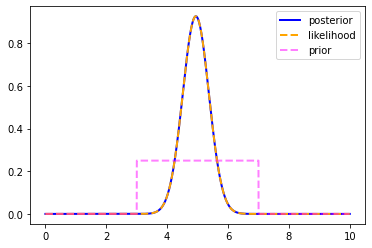

In [487]:
# (3) Compute and plot the Bayesian posterior probability density (not the log posterior) for the mean voltage 
# assuming a uniform prior for the mean in the range 3 to 7. Make sure this posterior pdf is normalized!

sums = []
probsum = []
mu_grid = np.linspace(0,10,10000)
# pri = np.linspace(3,7,100)#/(7-3)
pri = np.repeat(1,len(mu_grid))/(7-3) # prior is equal to mu_grid range, so it's fine
pri[(mu_grid<3)] = 0
pri[(mu_grid>7)] = 0

for i in range(len(mu_grid)):
#     logpdf = norm.logpdf(meas,loc=pri[i],scale=uncert)
#     sums.append(np.sum(logpdf)) # taking sum instead of product because we already took the log
#   can also find pdf and then take sum instead...gives the same result, but with a warning message. 
    pdf = norm.pdf(meas,loc=mu_grid[i],scale=uncert)
    probsum.append(np.product(pdf))
L = np.array(probsum)
# L = np.array(sums)
post = L*pri
# plt.plot(pri, post, label='posterior',lw=2)
plt.plot(mu_grid, post/(np.sum(post) * (mu_grid[1]-mu_grid[0])), label='posterior',c='b',lw=2)
plt.plot(mu_grid, L/(np.sum(L) * (mu_grid[1]-mu_grid[0])), label='likelihood',c='orange',ls='--',lw=2)
plt.plot(mu_grid, pri, label='prior',c='magenta', alpha=0.5, ls='--',lw=2)
plt.legend()
plt.show()

In [498]:
np.sum(post/(np.sum(post)))/(mu_grid[1]-mu_grid[0])

999.9

In [500]:
np.sum(post/(np.sum(post) * (mu_grid[1]-mu_grid[0])))
np.sum(post/(np.sum(post)))
post/(np.sum(post))
#cdf = sum(pdf)*dx

array([0., 0., 0., ..., 0., 0., 0.])

In [457]:
# TRYING TO FOLLOW LECTURE 10

# (4) By either drawing samples from this posterior, or using your gridded posterior pdf to make a cdf, find the 
# equal-tailed 68.3% credible region for the mean, and compare the upper and lower boundaries to the sample mean 
# plus/minus the standard error, respectively. Also find the MAP value of the mean.

"""# L = norm.cdf(L*pri)
cdf = np.cumsum(post)
"""

# Area = integral(pdf.dx) = sum(pdf)*dx = 
samples = np.random.choice(mu_grid, size=10000, p=post/np.sum(post)) # gives "probabilities do not sum to 1" error 
                                                                    # if not normalized by 'np.sum(post)'
# can make a histogram of sam
# 68% equal-tailed credible region
lower, upper = np.percentile(samples,q=16), np.percentile(samples,q=84)
# MAP value
hist, bins = np.histogram(samples, bins=50)
bin_mid = 0.5 * (bins[1:] + bins[:-1])
idx = np.argsort(hist)[-1]
map_theta = bin_mid[idx]

print('68% credible region = ' + str(lower) + ' to ' + str(upper))
# sample mean plus/minus the standard error
print('While sample mean plus/minus the standard error:')
print(str(sample_mu-error),'to',str(sample_mu+error))
# MAP value of the mean
print('MAP value = ' + str(map_theta))

68% credible region = 4.516291629162916 to 5.367536753675368
While sample mean plus/minus the standard error:
4.511874868373253 to 5.372361560477355
MAP value = 4.9395339533953395


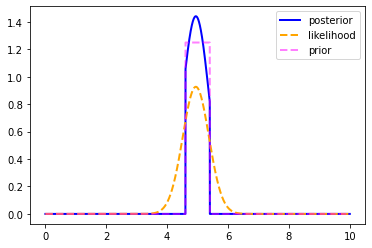

In [458]:
# (5) Repeat (3) and (4) this time with a prior on the mean that is uniform in the range 4.6 to 5.4.

probsum = []
mu_grid = np.linspace(0,10,10000)
pri = np.repeat(1,len(mu_grid))/(5.4-4.6) # square b/n 5.4 & 4.6
pri[(mu_grid<4.6)] = 0
pri[(mu_grid>5.4)] = 0 # prior is limiting this pdf

for i in range(len(mu_grid)):
    pdf = norm.pdf(meas,loc=mu_grid[i],scale=uncert)
    probsum.append(np.product(pdf))
L = np.array(probsum)

post2 = L*pri

plt.plot(mu_grid, post2/(np.sum(post2) * (mu_grid[1]-mu_grid[0])), label='posterior',c='b',lw=2)
plt.plot(mu_grid, L/(np.sum(L) * (mu_grid[1]-mu_grid[0])), label='likelihood',c='orange',ls='--',lw=2)
plt.plot(mu_grid, pri, label='prior',c='magenta',alpha=0.5,ls='--',lw=2)
plt.legend()
plt.show()


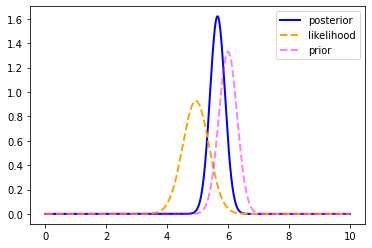

In [459]:
# (6) Now, imagine that we read an old paper about the experiment that gave us the voltage measurements, 
# and they found that the mean was actually  6±0.3 . Repeat (3) and (4) this time with a Gaussian prior on 
# the mean centered at  6  with standard deviation of  0.3 
probsum = []
mu_grid = np.linspace(0,10,10000)
pri = norm.pdf(mu_grid,6,0.3)

for i in range(len(mu_grid)):
    pdf = norm.pdf(meas,loc=mu_grid[i],scale=uncert)
    probsum.append(np.product(pdf))
L = np.array(probsum)

post3 = L*pri

plt.plot(mu_grid, post3/(np.sum(post3) * (mu_grid[1]-mu_grid[0])), label='posterior',c='b',lw=2)
plt.plot(mu_grid, L/(np.sum(L) * (mu_grid[1]-mu_grid[0])), label='likelihood',c='orange',ls='--',lw=2)
plt.plot(mu_grid, pri, label='prior',c='magenta', alpha=0.5, ls='--',lw=2)
plt.legend()
plt.show()

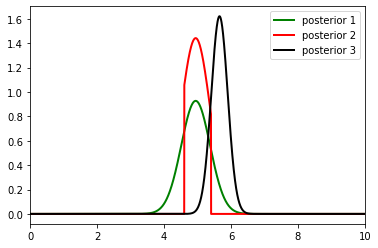

In [460]:
# (7) Plot all of the normalized posterior pdfs for  𝜇  from (3), (5), and (6) on the same plot, making sure 
# that the xlim of the plot spans 0 to 10.

plt.plot(mu_grid, post/(np.sum(post) * (mu_grid[1]-mu_grid[0])), label='posterior 1',c='g',lw=2)
plt.plot(mu_grid, post2/(np.sum(post2) * (mu_grid[1]-mu_grid[0])), label='posterior 2',c='r',lw=2)
plt.plot(mu_grid, post3/(np.sum(post3) * (mu_grid[1]-mu_grid[0])), label='posterior 3',c='k',lw=2)
plt.legend()
plt.xlim(0,10)
plt.show()

In [461]:
value = beta_squared[0]

absolute_val_array = np.abs(mu_grid - value)
# print(absolute_val_array)
smallest_difference_index = absolute_val_array.argmin()
closest_element = mu_grid[smallest_difference_index]

print(closest_element)

idx = np.where((mu_grid>=beta_squared[0]) & (mu_grid<beta_squared[0]+0.001))[0]
print(mu_grid[idx])

4.942494249424943
[4.94249425]


In [475]:
np.where(prior==1)

(array([4942]),)

In [474]:
np.where(post_new!=0)

(array([4942]),)

In [476]:
# (8)  You have made sure that the posterior pdfs are properly normalized, but until now you have ignored the 
# meaning of that normalization constant. It is the Bayesian evidence for the particular model you have applied! 
# Compute the evidence under a new model where the prior for the mean is a delta function at the best-fit value 
# you found in (1) (think about this and don't just immediately go looking for a scipy.stats delta function). 
# Compare this to the evidence found under the prior in (3). Taking ratios to make a Bayes factor, which model 
# is favored? Is there much of an Occam penalty by having the wide prior compared to knowing the mean exactly?

from scipy import signal
# prior for the mean is a delta function at the best-fit value found in (1)
prior = signal.unit_impulse(len(L),idx) # the delta function: 1, and 0 everywhere that it's not that value
# find the likelihood value at that location with a delta function spike. That should be the value of the evidence. 
# wherever the delta function is...the value with the likelihood at that value(position) and you'll get the evidence. 
evidence1 = np.sum(post) * (mu_grid[1]-mu_grid[0])
post_new = L*prior
# likelihood*prior(delta function)
# don't need to include the infinitesimal in evidence calculation
# pull out value of pdf at the position of the delta function (the delta function is already normalized
# so that it takes into account that infinitesimal) 
# So you should be able to just evaluate Likelihood*prior at the position of the delta function...this = the evidence
evidence2 = np.sum(post_new) #* (mu_grid[1]-mu_grid[0])
print('Evidence under uniform prior:',evidence1)
print('Evidence under delta fcn. prior:',evidence2)

odds = evidence1/evidence2
# “strong” evidence in favor of  evidence1  ( evidence1  is 'odds' times more probable than evidence2 )
print(odds, ', evidence2 is more probable than evidence1')
# print('I think this is wrong b/c the delta function gives the exact mean, and should therefore be the better model')

# Lecture 9
# Occam: All else being equal (i.e., each model fits the data equally well), the less complex model is favored.

Evidence under uniform prior: 2.8918714615457667e-08
Evidence under delta fcn. prior: 1.0725967252258747e-07
0.2696140491140113 , evidence1 is more probable than evidence2
I think this is wrong b/c the delta function gives the exact mean, and should therefore be the better model


## Problem 2

This problem uses a dataset in `/coursework/homeworks/hw_data/`.

1) Read in `hw4_data_2.npy`, which is a (3 x 20) numpy array that you used in `Lecture_9`. Set `x, y, sigma_y = data`. 

We're going to do some polynomial fits to this data just like in the lecture. However, in all cases you should **keep the $y$-intercept fixed at $-0.23$**. 

2) Use the following code to compute the un-normalized posterior pdf (i.e. just the likelihood x prior) on a grid of the linear coefficient (i.e. the slope) of a linear model, with a uniform prior between 0.5 and 1.5. Plot this posterior pdf. Remember this is just a one-dimensional model because the $y$-intercept is fixed. I advise a grid size of 100.

In [377]:
#Functions to do a polynomial fit, and compute the likelihood
def polynomial_fit(theta, x):
    """Polynomial model of degree (len(theta) - 1)"""
    # For a polynomial with order 1, this gives theta_0 + theta_1*x
    # For a polynomial with order 2, this gives theta_0 + theta_1*x + theta_2*x^2, etc.
    return sum(t * x ** n for (n, t) in enumerate(theta))

# compute the data log-likelihood given a model
def logL(theta, data, model=polynomial_fit):
    """Gaussian log-likelihood of the model at theta"""
    x, y, sigma_y = data
    y_fit = model(theta, x)
    return sum(scipy.stats.norm.logpdf(*args) 
               for args in zip(y, y_fit, sigma_y))

3) Using your 1D gridded likelihood-x-prior, compute the Bayesian evidence of this linear model. This may be a big number!

4) Now compute the joint 2D posterior pdf (again just the likelihood x prior) of linear and quadratic coefficients of a quadratic model. Give the linear coefficient a uniform prior between 0.5 and 1.5. Give the quadratic coefficient a uniform prior between -1 and 0.25. Plot this two-dimensional posterior. Remember this is a two-dimensional model because the $y$-intercept is fixed. I advise a grid size of 100 in each model dimension.

5) Using your 2D gridded likelihood-x-prior, compute the Bayesian evidence of the quadratic model. 

6) Calculate the Bayes factor for a linear versus quadratic model. How does this compare/contrast with the BIC model comparison in the lecture? 

### Solution

In [376]:
# (1) Read in hw4_data_2.npy, which is a (3 x 20) numpy array that you used in Lecture_9. Set x, y, sigma_y = data.
data2 = np.load("../../homeworks/hw_data/hw4_data_2.npy")
# 
x, y, sigma_y = data2
# We're going to do some polynomial fits to this data just like in the lecture. However, in all cases you should 
# keep the  𝑦 -intercept fixed at  −0.23 .

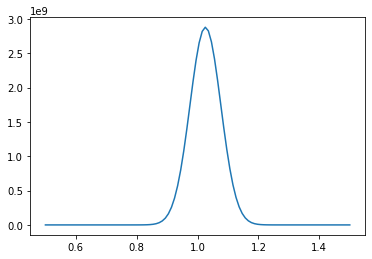

In [403]:
# (2) Use the following code to compute the un-normalized posterior pdf (i.e. just the likelihood x prior) on a 
# grid of the linear coefficient (i.e. the slope) of a linear model, with a uniform prior between 0.5 and 1.5. 
# Plot this posterior pdf. Remember this is just a one-dimensional model because the  𝑦 -intercept is fixed. 
# I advise a grid size of 100.

# give it an array of theta values
pri = np.repeat(1,100)/(1.5-0.5)

xgrid = np.linspace(0.5,1.5,100)
logls = []

for i in xgrid:
    thetas = np.concatenate(([-0.23], i), axis=None)
    likelihood = logL(thetas, data2, model=polynomial_fit)
    logls.append(likelihood)
    
posterior = np.log(np.repeat(1,100)/(1.5-0.5))+logls
posterior = np.exp(posterior)
plt.plot(xgrid,posterior)

# degree = 1
# theta_0 = (degree + 1) * [0]
# logL(theta_0, data2)

In [404]:
# (3) Using your 1D gridded likelihood-x-prior, compute the Bayesian evidence of this linear model. 
# This may be a big number!
b_evidence = np.sum(posterior)
b_evidence

36202788582.90529

In [482]:
# (4) Now compute the joint 2D posterior pdf (again just the likelihood x prior) of linear and quadratic 
# coefficients of a quadratic model. Give the linear coefficient a uniform prior between 0.5 and 1.5. 
# Give the quadratic coefficient a uniform prior between -1 and 0.25. Plot this two-dimensional posterior. 
# Remember this is a two-dimensional model because the  𝑦 -intercept is fixed. I advise a grid size of 100 
# in each model dimension.

lin_prior = np.repeat(1,100)/(1.5-0.5)
quad_prior = np.repeat(1,100)/(0.25-(-1))
xgrid = np.linspace(0.5,1.5,100) # linear coefficients
xgrid2 = np.linspace(-1,0.25,100) # quadratic coefficients

posterior_2d = []
posterior_matrix = []
q_lnlike = []
for i in range(len(xgrid)):
    posterior_2d = []
#     theta_lin = np.concatenate(([-0.23], xgrid[i]), axis=None)
#     lin_likelihood = logL(theta_lin, data2, model=polynomial_fit)
    for j in range(len(xgrid)):
        theta_quad = np.concatenate(([-0.23], xgrid[i], xgrid2[j]), axis=None)
        q_likelihood = logL(theta_quad, data2, model=polynomial_fit)
        q_lnlike.append(q_likelihood)
        post = np.log(quad_prior[j])+np.log(lin_prior[i])+q_likelihood
        posterior_2d.append(np.exp(post))
    posterior_matrix.append(posterior_2d)
#     lin_likelihood = logL(theta_lin, data2, model=polynomial_fit)
#     q_likelihood = logL(theta_quad, data2, model=polynomial_fit)
#     posterior_2d.append([lin_likelihood,q_likelihood])

np.shape(posterior_matrix)

(100, 100)

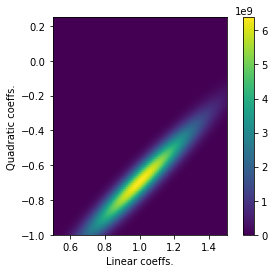

In [483]:
plt.imshow(posterior_matrix,
           extent = [np.amin(xgrid),np.amax(xgrid),np.amin(xgrid2),np.amax(xgrid2)]) #cmap="copper_r"
plt.colorbar()
plt.xlabel('Linear coeffs.')
plt.ylabel('Quadratic coeffs.')
# x an y axes are the indices of the array elements. Replace with actual coordinates of the linear & quad. coefficient
plt.show()

In [477]:
# (5) Using your 2D gridded likelihood-x-prior, compute the Bayesian evidence of the quadratic model.
np.sum(posterior_matrix)

3865992701792.664

In [503]:
# (6) Calculate the Bayes factor for a linear versus quadratic model. How does this compare/contrast 
# with the BIC model comparison in the lecture?
print(np.sum(posterior_matrix)/b_evidence)

# BIC model comparison: the model with the smaller BIC value wins
# BIC≡−2ln[𝐿0(𝑀)]+𝑘ln𝑁.
print(-2*np.amax(logls)+2*np.log(len(logls)))
print(-2*np.amax(q_lnlike)+3*np.log(len(q_lnlike)))
print('linear model better?')

106.78715240234725
-34.350369739219175
-17.96870481375471
linear model better?
